In [1]:
# Finding States of Majorana Chain using DMRG

using ITensors, ITensorMPS, PythonPlot

# Number of states to find
global R = 1

# Length of the spin chain
global L = 4
global sites = siteinds("S=1/2", L)

# Coupling coefficients
global lambdaI = 1
global lambda3 = 1

# Number of sweeps, bond dimensions, and cutoff for DMRG algorithm
nsweeps = 20
global maxdim = [10, 33, 66, 133]
global cutoff = 1e-8

# Create the Hamiltonian (HI) of the Ising chain
osI = OpSum()
for j in 1:L
    osI -= "X", j
    osI -= "Z", j, "Z", mod1(j+1, L)
end
HI = MPO(osI, sites)

# Create the Hamiltonian (H3) of the three-spin interaction
os3 = OpSum()
for j in 1:L
    os3 += "X", j, "Z", mod1(j+1, L), "Z", mod1(j+2, L)
    os3 += "Z", j, "Z", mod1(j+1, L), "X", mod1(j+2, L)
end
H3 = MPO(os3, sites)

# Full Hamiltonian
global H = 2 * lambdaI * HI + lambda3 * H3

# Create random initial conditions
psi0 = random_mps(sites)
global psi = Vector{MPS}(undef, R)
global energies = zeros(R)

# Run DMRG algorithm
observer = DMRGObserver(; energy_tol=cutoff)
println("Maxdim per sweep: ", maxdim)
println()

    # Run once to find a ground state
    println("DMRG run 1:")
    energies[1], psi[1] = dmrg(H, psi0; nsweeps, maxdim, cutoff, observer=observer)
    println("Final energy for DMRG run 1: $(energies[1])")
    println()

    # Find subsequent states while forcing orthogonality
    for i in 2:R
        println("DMRG run $i:")
        energies[i], psi[i] = dmrg(H, psi[1:(i-1)], psi0; nsweeps, maxdim, cutoff, weight=100, observer=observer)
        println("Final energy for DMRG run $i: $(energies[i])")
        println()
    end

# Sort and label the states
global sorted_indices = sortperm(energies)
println("Energy results from DMRG in ascending order:")
for (i, idx) in enumerate(sorted_indices)
    println("State $i: $(energies[idx])")
end

# Analyze overlap between states
n_total = length(sorted_indices)
overlap_matrix = zeros(ComplexF64, n_total, n_total)
for (i, idx_i) in enumerate(sorted_indices)
    for (j, idx_j) in enumerate(sorted_indices)
        overlap_matrix[i, j] = inner(psi[idx_i], psi[idx_j])
    end
end
println("\nNormalizations:")
for (i, idx) in enumerate(sorted_indices)
    norm_val = abs(overlap_matrix[i,i])
    println("State $i: ⟨ψ$idx|ψ$idx⟩ = $(round(norm_val, digits=8))")
end
println("\nInner product between states:")
for i in 1:n_total
    for j in (i+1):n_total
        overlap_val = abs(overlap_matrix[i,j])
        println("⟨ψ$(sorted_indices[i])|ψ$(sorted_indices[j])⟩ = $overlap_val")
    end
end

Maxdim per sweep: [10, 33, 66, 133]

DMRG run 1:
After sweep 1 energy=-7.999705085393413  maxlinkdim=4 maxerr=8.88E-16 time=10.355
After sweep 2 energy=-7.999999796823205  maxlinkdim=3 maxerr=6.40E-09 time=0.003
After sweep 3 energy=-7.9999999990692015  maxlinkdim=3 maxerr=2.32E-15 time=0.002
After sweep 4 energy=-7.99999999999572  maxlinkdim=3 maxerr=8.40E-17 time=0.003
Energy difference less than 1.0e-8, stopping DMRG
Final energy for DMRG run 1: -7.99999999999572

Energy results from DMRG in ascending order:
State 1: -7.99999999999572

Normalizations:
State 1: ⟨ψ1|ψ1⟩ = 1.0

Inner product between states:


Evolving state 1 with energy: -7.99999999999572

Trotter step = 0.0012566370614359175
Total steps = 2000

Final overlap with initial state: 0.146388
Final energy: -3.087832
Change in energy: 4.912168
<psi(0)|O*U(t)†*O*U(t)|psi(0)> = -0.11886410870798901


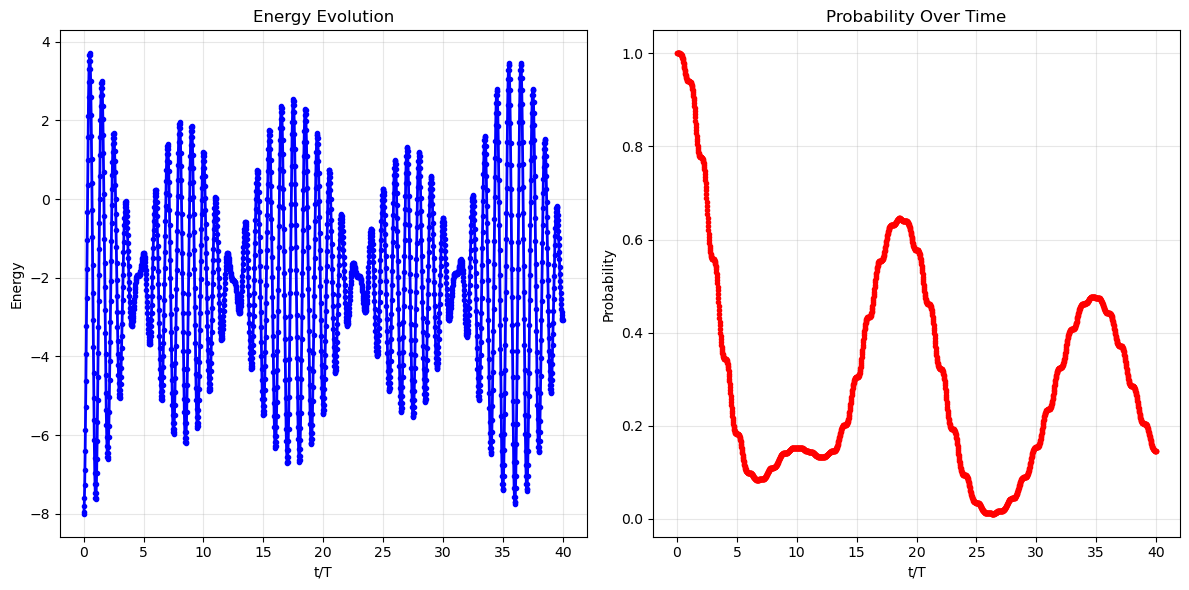

Python: None

In [4]:
# Time Evolution Under Driven Hamiltonian

using LinearAlgebra, DataFrames, CSV

# Choose which state to evolve
state_idx = 1
psi0 = psi[sorted_indices[state_idx]]
initial_energy = energies[sorted_indices[state_idx]]
println("Evolving state $state_idx with energy: $initial_energy")
println()

# Parameters
w = 100
T = 2π/w
N = 50
n_periods = 40

drive_lambdaI(t) = lambdaI*cos(w*t)

# Trotter step and total evolution time
tau = T/N 
total_time = n_periods * T
n_steps = n_periods * N
# n_steps = Int(total_time / tau)
println("Trotter step = $tau")
println("Total steps = $n_steps")
println()

# Midpoints of each step
midpoints = [tau*(n + 0.5) for n in 0:(N-1)]

# Build Trotter gates for the Hamiltonian
function build_trotter_gates(sites, tau, t)
    L = length(sites)
    gates = ITensor[]

    current_lambdaI = drive_lambdaI(t)
    
    # Forward sweep
    for j in 1:L
        s1, s2, s3 = sites[j], sites[mod1(j+1, L)], sites[mod1(j+2, L)]
        
        # Build term for Ising part HI
        X_part = -(1/3) * (op("X", s1) * op("Id", s2) * op("Id", s3) +
                           op("Id", s1) * op("X", s2) * op("Id", s3) +
                           op("Id", s1) * op("Id", s2) * op("X", s3))
        ZZ_part = -op("Z", s1) * op("Z", s2) * op("Id", s3)
        HI = X_part + ZZ_part
        
        # Build term for Three-spin part H3
        H3 = op("X", s1) * op("Z", s2) * op("Z", s3) +
             op("Z", s1) * op("Z", s2) * op("X", s3)

        # Define full Hamiltonian and create gate
        H = 2 * current_lambdaI * HI + lambda3 * H3
        push!(gates, exp(-im * tau/2 * H))
    end
    
    # Backward sweep
    append!(gates, reverse(gates))
    return gates
end

# Compute gates for each midpoint in one full period
gate_sets = []
for t_mid in midpoints
    gates = build_trotter_gates(sites, tau, t_mid)
    push!(gate_sets, gates)
end

# Build Time-Dependent Hamiltonian
function H_time(t)
    os = OpSum()
    for j in 1:L
        os += -2 * drive_lambdaI(t), "X", j
        os += -2 * drive_lambdaI(t), "Z", j, "Z", mod1(j+1, L)
        os += lambda3, "X", j, "Z", mod1(j+1, L), "Z", mod1(j+2, L)
        os += lambda3, "Z", j, "Z", mod1(j+1, L), "X", mod1(j+2, L)
    end
    return MPO(os, sites)
end

# Time evolution
psi_evolved = copy(psi0)
times = Float64[]
energy_vals = Float64[]
overlap_vals = Float64[]

# Initial conditions
H0 = H_time(0.0)
push!(times, 0.0)
push!(energy_vals, real(inner(psi0', H0, psi0)))
push!(overlap_vals, 1.0)

# Time evolution loop which creates unitary U(t)
for step in 1:n_steps

    set_index = mod(step-1, N) + 1
    current_gates = gate_sets[set_index]
    
    # Apply one full Trotter step and normalize
    psi_evolved = apply(current_gates, psi_evolved; cutoff=cutoff, maxdim=maximum(maxdim))
    normalize!(psi_evolved) # psi(t) = U(t)|psi(0)>
    
    # Take measurement at the end of the step
    current_time = step * tau
    if step % 1 == 0 || step == n_steps
        
        # Get Hamiltonian at current time
        H_current = H_time(current_time)
        
        energy = real(inner(psi_evolved', H_current, psi_evolved))
        overlap = abs2(inner(psi0, psi_evolved))
        
        # Store for plotting
        push!(times, current_time)
        push!(energy_vals, energy)
        push!(overlap_vals, overlap)
    end
end

# Creates function that applies an operator O to a wave function
function apply_O(psi, sites)
    return apply(op("Z", sites[1]), psi)
end

#apply_O(psi, sites) = psi # This is a sanity check which should give us a result of 1

# |theta> = O*|psi(t)> = O*U(t)|psi(0)>
theta = apply_O(psi_evolved, sites)
normalize!(theta)

# |phi(0)> = O*|psi(0)>
phi = apply_O(psi0, sites)
normalize!(phi)

# Applies U(t) to |phi>
for step in 1:n_steps
     set_index = mod(step-1, N) + 1
     current_gates = gate_sets[set_index]

    phi = apply(current_gates, phi; cutoff=cutoff, maxdim=maximum(maxdim))
    normalize!(phi) # |phi(t)> = U(t)*|phi(0)> = U(t)*O*|psi(0)>
end

something = real(inner(phi, theta))

# Final results
final_overlap = overlap_vals[end]
final_energy = energy_vals[end]

println("Final overlap with initial state: $(round(final_overlap, digits=6))")
println("Final energy: $(round(final_energy, digits=6))")
println("Change in energy: $(round(abs(final_energy - initial_energy), digits=6))")
println("<psi(0)|O*U(t)†*O*U(t)|psi(0)> = $(something)")


# # Print to .csv
# df = DataFrame("time" => times, "return_probability" => overlap_vals)
# CSV.write("Probability_vs_Time_L=$(L).csv", df)
# println("Exported to: Probability_vs_Time_L=$(L).csv")

# Plotting
fig, (ax1, ax2) = PythonPlot.subplots(1, 2, figsize=(12, 6))
    
    # Energy
    ax1.plot(times/T, energy_vals, "b.-", linewidth=2)
    ax1.set_xlabel("t/T")
    ax1.set_ylabel("Energy")
    ax1.grid(true, alpha=0.3)
    ax1.set_title("Energy Evolution")
    
    # Overlap
    ax2.plot(times/T, overlap_vals, "r.-", linewidth=2)
    ax2.set_xlabel("t/T")
    ax2.set_ylabel("Probability")
    ax2.grid(true, alpha=0.3)
    ax2.set_title("Probability Over Time")

PythonPlot.tight_layout()

In [ ]:
# Time Evolution Under Full Hamiltonian

using LinearAlgebra

# Choose which state to evolve
state_idx = 1
psi0 = psi[sorted_indices[state_idx]]
initial_energy = energies[sorted_indices[state_idx]]
println("Evolving state $state_idx with energy: $initial_energy")
println()

# Trotter step and total evolution time
tau = 0.1 
total_time = 2.0
n_steps = Int(total_time / tau)
println("Trotter step = $tau")
println("Total steps = $n_steps")
println()

# Build Trotter gates for the Hamiltonian
function build_trotter_gates(sites, tau)
    L = length(sites)
    gates = ITensor[]
    
    # Forward sweep
    for j in 1:L
        s1, s2, s3 = sites[j], sites[mod1(j+1, L)], sites[mod1(j+2, L)]
        
        # Build term for Ising part HI
        X_part = -(1/3) * (op("X", s1) * op("Id", s2) * op("Id", s3) +
                           op("Id", s1) * op("X", s2) * op("Id", s3) +
                           op("Id", s1) * op("Id", s2) * op("X", s3))
        ZZ_part = -op("Z", s1) * op("Z", s2) * op("Id", s3)
        HI = X_part + ZZ_part
        
        # Build term for Three-spin part H3
        H3 = op("X", s1) * op("Z", s2) * op("Z", s3) +
             op("Z", s1) * op("Z", s2) * op("X", s3)

        # Define full Hamiltonian and create gate
        H = 2 * lambdaI * HI + lambda3 * H3
        push!(gates, exp(-im * tau/2 * H))
    end
    
    # Backward sweep
    append!(gates, reverse(gates))
    return gates
end

# Initialize by building gates once
t_gates = build_trotter_gates(sites, tau)

# Time evolution
psi_evolved = copy(psi0)
times = Float64[]
energy_vals = Float64[]
overlap_vals = Float64[]

# Initial conditions
push!(times, 0.0)
push!(energy_vals, real(inner(psi0', H, psi0)))
push!(overlap_vals, 1.0)

# Time evolution loop
for step in 1:n_steps
    
    # Apply one full Trotter step and normalize
    psi_evolved = apply(t_gates, psi_evolved; cutoff=cutoff, maxdim=maximum(maxdim))
    normalize!(psi_evolved)
    
    # Take measurement every 1 step(s) or at the end
    current_time = step * tau
    if step % 1 == 0 || step == n_steps
        energy = real(inner(psi_evolved', H, psi_evolved))
        overlap = abs(inner(psi0, psi_evolved))
        
        # Store for plotting
        push!(times, current_time)
        push!(energy_vals, energy)
        push!(overlap_vals, overlap)
    end
end

# Final results
final_overlap = overlap_vals[end]
final_energy = energy_vals[end]
println("Final overlap with initial state: $(round(final_overlap, digits=6))")
println("Final energy: $(round(final_energy, digits=6))")
println("Change in energy: $(round(abs(final_energy - initial_energy), digits=6))")

# Plotting
fig, (ax1, ax2) = PythonPlot.subplots(1, 2, figsize=(12, 6))
    
    # Energy
    ax1.plot(times, energy_vals, "b.-", linewidth=2)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Energy")
    ax1.grid(true, alpha=0.3)
    ax1.set_title("Energy Evolution")
    
    # Overlap
    ax2.plot(times, overlap_vals, "r.-", linewidth=2)
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Overlap with initial state")
    ax2.grid(true, alpha=0.3)
    ax2.set_title("State Overlap")

PythonPlot.tight_layout()
fig

In [ ]:
# Z-Z Correlations

using PythonPlot, LaTeXStrings

# Clear variables
ZZC = Vector{Matrix{ComplexF64}}(undef, R)
real_ZZC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute Z-Z correlations matrices for all states
for i in 1:R
    ZZC[i] = correlation_matrix(psi[sorted_indices[i]], "Z", "Z")
end

# Get the real values of correlations
for i in 1:R
    real_ZZC[i] = real.(ZZC[i][1, 2:end])
end

figure(figsize=(10, 6))

# Plot the Z-Z correlations for ground states
for i in 1:R
    x[i] = collect(1:length(real_ZZC[i]))
    plot(x[i], real_ZZC[i], marker="o", linestyle="-", linewidth=1.5, label="State $(sorted_indices[i])")
end

legend(fontsize=9)
xlabel(L"L", labelpad=15)
ylabel(L"\langle \psi | Z_i Z_j | \psi \rangle", rotation=0, labelpad=30)
title("Z-Z Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Print max and min values
println("Maximum and Minimum Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): $(round(maximum(real_ZZC[i]), digits=3)), $(round(minimum(real_ZZC[i]), digits=3))")
end

In [ ]:
# X-X Correlations

using PythonPlot, LaTeXStrings

# Clear variables
XXC = Vector{Matrix{ComplexF64}}(undef, R)
real_XXC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute X-X correlations matrices for all states
for i in 1:R
    XXC[i] = correlation_matrix(psi[sorted_indices[i]], "X", "X")
end

# Get the real values of correlations
for i in 1:R
    real_XXC[i] = real.(XXC[i][1, 2:end])
end

figure(figsize=(10, 6))

# Plot the X-X correlations for ground states
for i in 1:R
    x[i] = collect(1:length(real_XXC[i]))
    plot(x[i], real_XXC[i], marker="o", linestyle="-", linewidth=1.5, label="State $(sorted_indices[i])")
end

legend(fontsize=9)
xlabel(L"L", labelpad=15)
ylabel(L"\langle \psi | X_i X_j | \psi \rangle", rotation=0, labelpad=30)
title("X-X Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Print max and min values
println("Maximum and Minimum Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): $(round(maximum(real_XXC[i]), digits=3)), $(round(minimum(real_XXC[i]), digits=3))")
end

In [ ]:
# Connected Z-Z Correlations

using PythonPlot, LaTeXStrings, Statistics

plot_toggle = false

# Select state to analyze (only relevant if plot_toggle = true)
select_state = 1

# Clear variables
ZZCC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute connected Z-Z correlations for all states
for i in 1:R
    corr_matrix = correlation_matrix(psi[sorted_indices[i]], "Z", "Z")
    Z_exp = [real(expect(psi[sorted_indices[i]], "Z"; sites=j)) for j in 1:L]

    ccorrs = Vector{Float64}(undef, L-1)
    for j in 2:L
        RHS = Z_exp[1] * Z_exp[j]
        ccorrs[j-1] = real(corr_matrix[1, j]) - RHS
    end
    ZZCC[i] = ccorrs
end

figure(figsize=(10, 6))

# Plot the connected Z-Z correlations
if plot_toggle == true
    # Plot the selected state in log-log mode
    x[select_state] = collect(1:length(ZZCC[select_state]))
    plot(sin.(x[select_state] .* pi ./ L), ZZCC[select_state],
         marker="o", linestyle="-", linewidth=1.5,
         label="State $(sorted_indices[select_state])")

    xscale("log"); yscale("log")
    xlabel(L"\sin{\left(\frac{x\pi}{L}\right)}")
    ylabel(L"\langle\psi|Z_iZ_j|\psi\rangle - \langle\psi|Z_i|\psi\rangle \langle\psi|Z_j|\psi\rangle", rotation=0, labelpad=75)
    title("Connected Z-Z Correlations of State $(sorted_indices[select_state])")

    # X and Y coordinates plotted on the log–log graph
    xvals = sin.(x[select_state] .* pi ./ L)
    yvals = ZZCC[select_state]

    # Filter out invalid points and take logs
    valid = findall(k -> xvals[k] > 0 && yvals[k] > 0 && k > 9, eachindex(xvals)) # Do not include the first 9 sites
    log_x = log.(xvals[valid])
    log_y = log.(yvals[valid])

    # Build regression matrix and solve least‑squares fit
    design_matrix = hcat(ones(length(log_x)), log_x)
    β = design_matrix \ log_y
    slope, intercept = β[2], β[1]

    # Print slope and scaling dimension
    println("Estimated slope of state $(sorted_indices[select_state]): ",
            round(slope, digits=4))
    println("Estimated scaling dimension: ",
            round(-slope/2, digits=4))
    println()

    # Overlay fit line
    plot(xvals[valid], exp.(intercept .+ slope .* log_x), "--", label="Best Fit Line")

else
    # Plot all states normally
    for i in 1:R
        x[i] = collect(1:length(ZZCC[i]))
        plot(x[i], ZZCC[i], marker="o", linestyle="-", linewidth=1.5,
             label="State $(sorted_indices[i])")
    end

    xlabel(L"L", labelpad=15)
    ylabel(L"\langle\psi|Z_iZ_j|\psi\rangle - \langle\psi|Z_i|\psi\rangle \langle\psi|Z_j|\psi\rangle", rotation=0, labelpad=75)
    title("Connected Z-Z Correlations Between Site 1 and Site L")
end

legend(fontsize=9)
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Print max and min values
println("Maximum and Minimum Connected Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): ",
            round(maximum(ZZCC[i]), digits=3), ", ",
            round(minimum(ZZCC[i]), digits=3))
end

In [ ]:
# Connected X-X Correlations

using PythonPlot, LaTeXStrings, Statistics

plot_toggle = false

# Select state to analyze (only relevant if plot_toggle = true)
select_state = 1

# Clear variables
XXCC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute connected X-X correlations for all states
for i in 1:R
    corr_matrix = correlation_matrix(psi[sorted_indices[i]], "X", "X")
    X_exp = [real(expect(psi[sorted_indices[i]], "X"; sites=j)) for j in 1:L]

    ccorrs = Vector{Float64}(undef, L-1)
    for j in 2:L
        RHS = X_exp[1] * X_exp[j]
        ccorrs[j-1] = real(corr_matrix[1, j]) - RHS
    end
    XXCC[i] = ccorrs
end

figure(figsize=(10, 6))

# Plot the connected X-X correlations
if plot_toggle == true
    # Plot the selected state in log-log mode
    x[select_state] = collect(1:length(XXCC[select_state]))
    plot(sin.(x[select_state] .* pi ./ L), XXCC[select_state],
         marker="o", linestyle="-", linewidth=1.5,
         label="State $(sorted_indices[select_state])")

    xscale("log"); yscale("log")
    xlabel(L"\sin{\left(\frac{x\pi}{L}\right)}")
    ylabel(L"\langle\psi|X_iX_j|\psi\rangle - \langle\psi|X_i|\psi\rangle \langle\psi|X_j|\psi\rangle", rotation=0, labelpad=75)
    title("Connected X-X Correlations of State $(sorted_indices[select_state])")

    # X and Y coordinates plotted on the log–log graph
    xvals = sin.(x[select_state] .* pi ./ L)
    yvals = XXCC[select_state]

    # Filter out invalid points and take logs
    valid = findall(k -> xvals[k] > 0 && yvals[k] > 0 && k > 9, eachindex(xvals)) # Do not include the first 9 sites
    log_x = log.(xvals[valid])
    log_y = log.(yvals[valid])

    # Build regression matrix and solve least‑squares fit
    design_matrix = hcat(ones(length(log_x)), log_x)
    β = design_matrix \ log_y
    slope, intercept = β[2], β[1]

    # Print slope and scaling dimension
    println("Estimated slope of state $(sorted_indices[select_state]): ",
            round(slope, digits=4))
    println("Estimated scaling dimension: ",
            round(-slope/2, digits=4))
    println()

    # Overlay fit line
    plot(xvals[valid], exp.(intercept .+ slope .* log_x), "--", label="Best Fit Line")

else
    # Plot all states normally
    for i in 1:R
        x[i] = collect(1:length(XXCC[i]))
        plot(x[i], XXCC[i], marker="o", linestyle="-", linewidth=1.5,
             label="State $(sorted_indices[i])")
    end

    xlabel(L"L", labelpad=15)
    ylabel(L"\langle\psi|X_iX_j|\psi\rangle - \langle\psi|X_i|\psi\rangle \langle\psi|X_j|\psi\rangle", rotation=0, labelpad=75)
    title("Connected X-X Correlations Between Site 1 and Site L")
end

legend(fontsize=9)
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Print max and min values
println("Maximum and Minimum Connected Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): ",
            round(maximum(XXCC[i]), digits=3), ", ",
            round(minimum(XXCC[i]), digits=3))
end